<a href="https://colab.research.google.com/github/bt22dr/PRML/blob/master/PRML_chapter_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 9. Mixture Models and EM

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install tensorflow-gpu==2.0.0-rc1

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import sys
import copy
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [0]:
from google.colab import files
files.upload()

In [0]:
# Next, install the Kaggle API client.
!pip install -U kaggle

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

# List available datasets.
# !kaggle datasets list
!kaggle datasets list --search old-faithful

# Download dataset
!kaggle datasets download -d janithwanni/old-faithful

# Unzip the dataset file
!unzip old-faithful.zip

In [3]:
URL = 'faithful.csv'
dataframe = pd.read_csv(URL)
dataframe = dataframe[['eruptions', 'waiting']]
dataframe.head()

,eruptions,waiting
0,3.600,79
1,1.800,54
2,3.333,74
3,2.283,62
4,4.533,85


In [4]:
standardScaler = StandardScaler()
standardScaler.fit(dataframe)
faithful_data = standardScaler.transform(dataframe)
print(faithful_data[:10])

[[ 0.09849886  0.59712344]
 [-1.48145856 -1.24518118]
 [-0.13586149  0.22866251]
 [-1.05750332 -0.6556437 ]
 [ 0.91744345  1.03927655]
 [-0.53085085 -1.171489  ]
 [ 1.06402839  1.2603531 ]
 [ 0.09849886  1.03927655]
 [-1.34979544 -1.46625773]
 [ 0.75681445  1.03927655]]


In [5]:
N = len(faithful_data)
D = 2
K = 2
print(N, D, K)

272 2 2


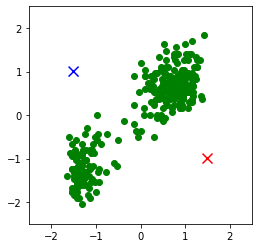

In [6]:
mu = tf.constant([[-1.5, 1],[1.5,-1]], dtype=tf.float32)

plt.figure(figsize=(4,4)); plt.xlim(-2.5,2.5); plt.ylim(-2.5,2.5)
plt.plot(faithful_data[:,0], faithful_data[:,1], 'go')
plt.scatter(mu[:,0], mu[:,1], c=['b', 'r'], s=100, marker="x")

In [0]:
class KMeans():
  def __init__(self, X, K):
    self.N = len(X)
    self.D = len(X[0])
    self.K = K
    self.X = X
    self.R = tf.ones_like(X)
    self.mu = tf.constant([[-1.5, 1],[1.5,-1]], dtype=tf.float32)
    self.loss = []

  def cost_function(self):
    R = self.R
    X = self.X
    mu = self.mu

    J = 0
    for n, r_n in enumerate(R):
      for k, r_nk in enumerate(r_n):
        J = J + r_nk.numpy() * tf.math.square(tf.norm(X[n] - mu[k])) # 식 9.1
    return J.numpy()

  def plot_current_state(self):
    K = self.K
    X = self.X
    mu = self.mu

    cols = ['b', 'r', 'y']
    plt.figure(figsize=(4,4)); plt.xlim(-2.5,2.5); plt.ylim(-2.5,2.5)
    for k in range(K):
      plt.scatter(X[self.cluster_k_idx[k],0], 
              X[self.cluster_k_idx[k],1], c=cols[k], s=30, marker="o")
    plt.scatter(mu[:,0], mu[:,1], c='w', s=400, marker="X")
    plt.scatter(mu[:,0], mu[:,1], c=cols[:K], s=100, marker="x")

  def train_one_step(self):
    X = self.X
    K = self.K
    mu = self.mu

    def step_E(): # update r_nk
      R = []
      for n in range(N):
        k = tf.argmin(tf.math.square(tf.norm(X[n] - mu, axis=-1)))
        r_n = tf.one_hot(k, depth=K, dtype=tf.int32) # 식 9.2
        R.append(r_n)
      self.R = tf.stack(R)

      self.cluster_k_idx = []
      for k in range(K):
        self.cluster_k_idx.append(tf.squeeze(tf.where(self.R[:,k])))

    def step_M(): # update mu_k
      mu = []
      for k in range(K):
        m = tf.reduce_mean(X[self.cluster_k_idx[k]], axis=0) # 식 9.4
        mu.append(m)
      self.mu = tf.stack(mu)

    step_E()
    self.plot_current_state()
    self.loss.append(self.cost_function())

    step_M()
    self.plot_current_state()
    self.loss.append(self.cost_function())

  def train(self, iter=100):
    for i in range(iter):
      J = self.cost_function()
      print("Iteration {}: cost {}".format(i, J))

      self.train_one_step()
      if tf.math.abs(self.loss[-1] - self.loss[-2]) < 1e-1:
        break

Iteration 0: cost 2855.99951171875
Iteration 1: cost 325.2789988495719
Iteration 2: cost 80.96792556114691
Iteration 3: cost 79.63566081947319


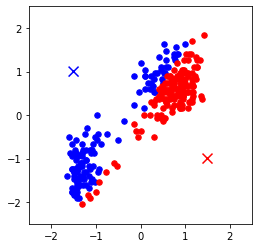

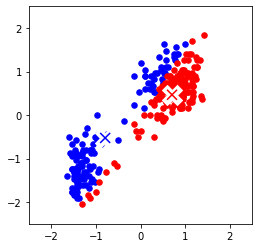

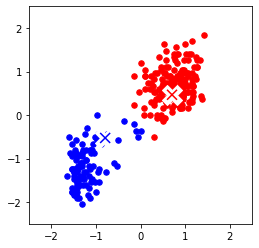

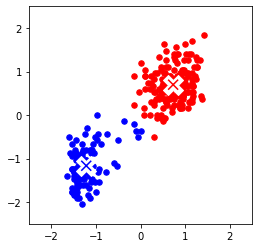

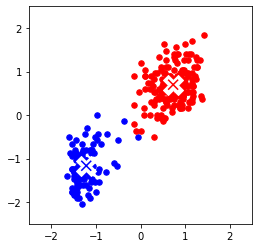

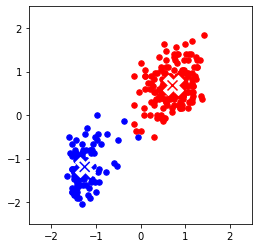

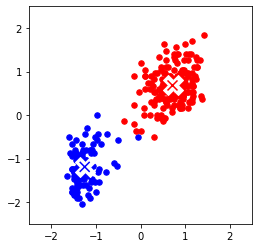

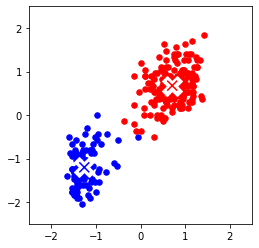

In [8]:
model = KMeans(faithful_data, 2)
model.train()

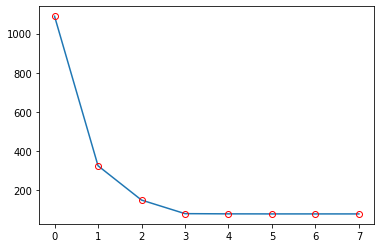

In [9]:
plt.plot(model.loss)
plt.plot(model.loss, 'ro', fillstyle='none')